# Example 1: Simulating a Traffic Network

In this example, we will use TRACKSIM to simulate vehicle traffic in a SUMO network. For the purposes of this example, we will simulate the charming city of Geldrop, Netherlands which has a population of around 29 thousand people (as of 2023). The corresponding SUMO scenario was created using the osmWebWizard tool from SUMO which is fast way to generate working SUMO scenarios. For more information about osmWebWizard, please refer to the documentation at https://sumo.dlr.de/docs/Tools/Import/OSM.html .

The traffic simulator is handled by the Traffic class in TRACKSIM.

In [1]:
from tracksim.tracksim import Traffic

Traffic?

Init signature:
Traffic(
    config_path: str,
    output_dir: str = 'simulated_trip_files',
    duration: int = 1,
    time_step: int | float = 1,
    record_position: bool = False,
    to_geo: bool = True,
    record_edge: bool = False,
    record_lane: bool = False,
    record_speed_limit: bool = False,
    data_retrieval_functions: list = None,
    sumo_options: dict | None = None,
    pbar: bool = True,
    checkpoint_len: int | None = 3600,
    checkpoint_dir: str = 'trip_checkpoints',
    lite_mode_ratio: int | float | None = None,
    random_state: int | str | None = None,
    remove_checkpoints_when_finished: bool = True,
) -> None
Docstring:     
Class used to define and run the traffic simulation. The main method of 
this class is 'simulate_traffic'.
Init docstring:
Initializes the Traffic class used for simulating the vehicle traffic. 

Parameters
----------
config_path : str
    The path to the SUMO configuration file for the scenario to be 
    simulated.

output_dir : st

The traffic class has multiple optional settings which can be configured (please refer to the docstring). However, it is required to give the path to the SUMO configuration file as input. In this example, we will only simulate 1 hour of traffic with a sample period of 1 second. Additionally, we will enable tracking of the position of each vehicle.

In [2]:
config_path = 'example_SUMO_scenarios/Geldrop/osm.sumocfg'

traffic = Traffic(config_path, duration=1, time_step=1, record_position=True, checkpoint_len=None)

The traffic simulation is done by the 'simulate_traffic' method.

In [3]:
traffic.simulate_traffic()


Starting simulation

Started simulation with timedelta: 1.0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3600/3600.0 [00:20<00:00, 172.88it/s]



 Finished simulation in 22.60 seconds!

Purging 'simulated_trip_files'


Once the simulation has finished, all trip files are found in a directory named 'simulated_trip_files'. The data from each trip is stored in a CSV file. The name of each trip file corresponds to the ID of the vehicle. Let's look at the data for one trip.

In [4]:
import pandas as pd

trip_file = 'simulated_trip_files/veh0.csv'
trip_data = pd.read_csv(trip_file)

trip_data.head()

,Time [s],Speed [m/s],Longitude,Latitude
0,0,0.000000,5.580990,51.418338
1,1,2.340035,5.580988,51.418317
2,2,4.327291,5.580986,51.418278
3,3,5.820755,5.580982,51.418226
4,4,8.417111,5.580976,51.418150


The trip data contains the time of the simulation, the speed of the vehicle in meters per second as well as the geographical coordinates of the vehicle.

The path of the vehicle can be plotted.

Text(0, 0.5, 'Latitude')

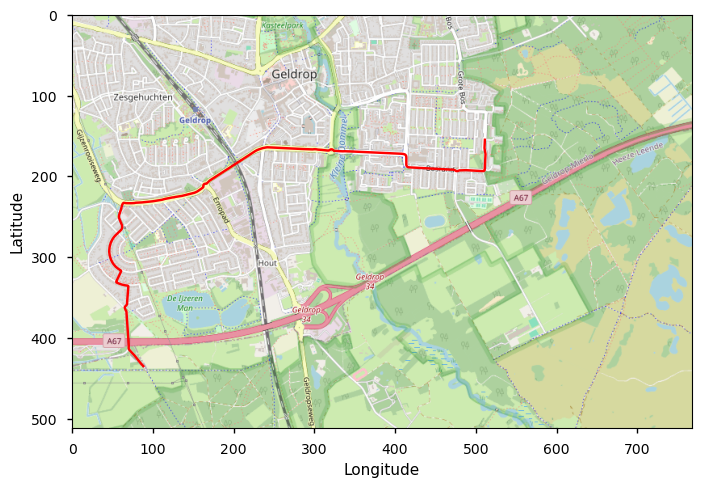

In [62]:
import smopy
from mpl_toolkits.axes_grid1 import make_axes_locatable

osm_map = smopy.Map((trip_data['Latitude'].min(), 
                     trip_data['Longitude'].min(), 
                     trip_data['Latitude'].max(), 
                     trip_data['Longitude'].max()), 
                    z=14)

fig, ax = plt.subplots(figsize=(8, 6))

ax = osm_map.show_mpl(ax=ax)

x, y = osm_map.to_pixels(trip_data['Latitude'], trip_data['Longitude'])

ax.plot(x, y, color='r')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Likewise, we can plot the speed of the vehicle over time.

Text(0, 0.5, 'Speed [km/h]')

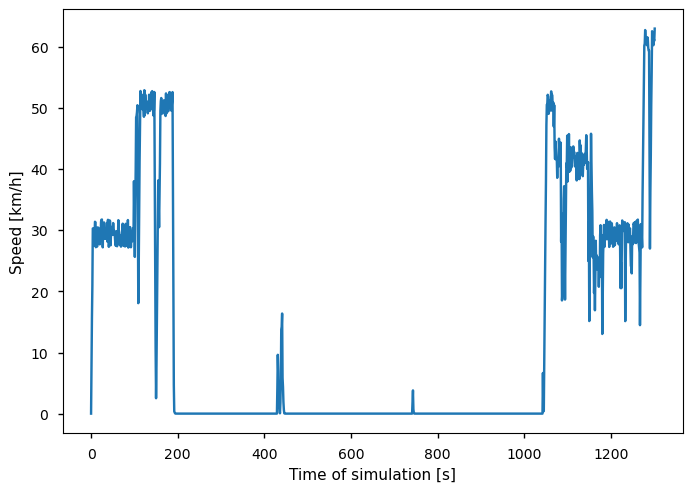

In [6]:
plt.figure()

plt.plot(trip_data['Time [s]'], trip_data['Speed [m/s]']*3.6) # Convert to km/h
plt.xlabel('Time of simulation [s]')
plt.ylabel('Speed [km/h]')

SUMO has a tendency to give speeds which can vary a lot over a short period of time. This can lead to high acceleration/deacceleration peaks and potentially unrealistic battery measurements. One way to mitigate this is to low-pass filter the speed profile. This can be done using an exponential moving average.

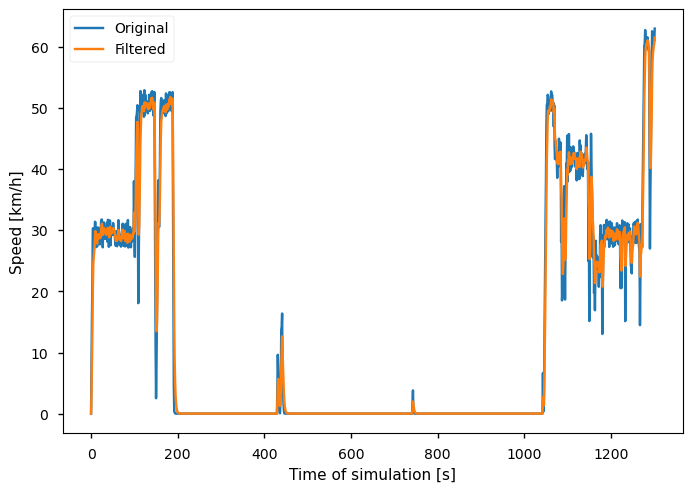

In [7]:
from tracksim.utils import exp_average

speed_filtered = exp_average(trip_data['Speed [m/s]'], alpha=0.4)

plt.figure()

plt.plot(trip_data['Time [s]'], trip_data['Speed [m/s]']*3.6, label='Original')
plt.plot(trip_data['Time [s]'], speed_filtered*3.6, label='Filtered')
plt.xlabel('Time of simulation [s]')
plt.ylabel('Speed [km/h]')
plt.legend()